### Maximum Entropy

This is inspired by [this StackExchange question](https://datascience.stackexchange.com/questions/107366/how-do-you-solve-strictly-constrained-optimization-problems-with-pytorch).

I am trying to solve the following problem using pytorch: given a six sided die whose average roll is known to be 4.5, what is the maximum entropy distribution for the faces?

In [16]:
from copy import deepcopy

import cooper
import matplotlib.pyplot as plt
import torch

from cooper import CMPState, ConstraintGroup, ConstraintState
from cooper.optim import SimultaneousConstrainedOptimizer

torch.manual_seed(7238)

In [17]:
class MaximumEntropy(cooper.ConstrainedMinimizationProblem):
    def __init__(
        self,
        mean_constraint: float,
        ineq_group: ConstraintGroup,
        eq_group: ConstraintGroup
    ) -> None:
        self.mean_constraint = mean_constraint
        self.ineq_group = ineq_group
        self.eq_group = eq_group
        super().__init__()

    def compute_cmp_state(self, probs: torch.Tensor) -> CMPState:
        # Verify domain of definition of the functions
        assert torch.all(probs >= 0)

        # Negative signed since we want to *maximize* the entropy
        entropy = torch.sum(probs * torch.log(probs))

        # Entries of p >= 0 (equiv. to -p <= 0)
        self.ineq_group.state = ConstraintState(violation=-probs)

        # Equality constraints for proper normalization and mean constraint
        mean = torch.sum(torch.tensor(range(1, len(probs) + 1)) * probs)
        self.eq_group.state = ConstraintState(
            violation=torch.stack([torch.sum(probs) - 1, mean - self.mean_constraint])
        )

        return CMPState(loss=entropy, observed_constraints=[self.ineq_group, self.eq_group])

In [24]:
probs = torch.nn.Parameter(torch.rand(6))

ineq_group = ConstraintGroup(
    constraint_type="ineq", shape=6, dtype=torch.float16, device=probs.device
)
eq_group = ConstraintGroup(
    constraint_type="eq", shape=2, dtype=torch.float16, device=probs.device
)

cmp = MaximumEntropy(mean_constraint=4.5, ineq_group=ineq_group, eq_group=eq_group)

primal_optimizer = torch.optim.SGD([probs], lr=3e-2, momentum=0.7)
dual_optimizer = torch.optim.SGD(
    [ineq_group.multiplier.weight, eq_group.multiplier.weight], lr=9e-3, momentum=0.7
)

optimizer = SimultaneousConstrainedOptimizer(
    constraint_groups=eq_group,
    primal_optimizers=primal_optimizer,
    dual_optimizers=dual_optimizer,
)

In [25]:
state_history = {}
for i in range(5000):
    optimizer.zero_grad()
    cmp_state = cmp.compute_cmp_state(probs)
    _ = cmp_state.populate_lagrangian()
    cmp_state.backward()
    optimizer.step()

    state_history[i] = {
        "loss": deepcopy(cmp_state.loss.data),
        "multipliers": deepcopy(eq_group.multiplier.weight.data),
        "violation": deepcopy(cmp_state.observed_constraints[1].state.violation.data),
    }

AssertionError: 

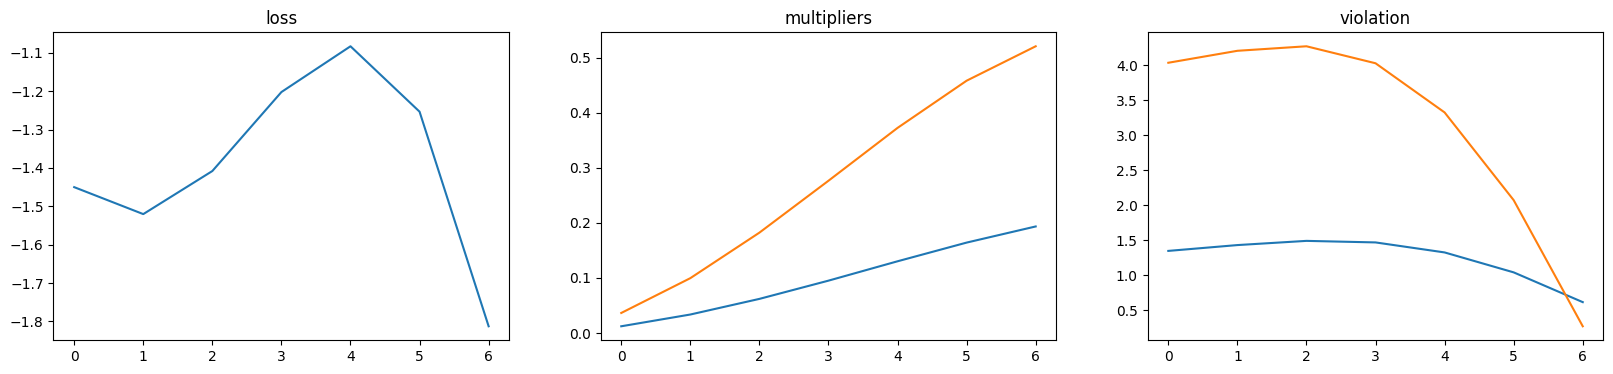

In [20]:
iters, loss_hist, multipliers_hist, violation_hist = zip(
        *[
            (k, v["loss"], v["multipliers"], v["violation"])
            for k, v in state_history.items()
        ]
    )

hist_list = [loss_hist, multipliers_hist, violation_hist]
hist_names = ["loss", "multipliers", "violation"]

_, ax = plt.subplots(1, len(hist_list), figsize=(20, 4))

for ax, hist, title in zip(ax, hist_list, hist_names):
    ax.plot(iters, torch.stack(hist).squeeze())
    ax.set_title(title)